<a href="https://colab.research.google.com/github/EkaterinaVoloshina/classification_of_dative_semantic_roles/blob/main/notebooks/supervised_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from math import log
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_curve, confusion_matrix, classification_report, f1_score
from sklearn.linear_model import LogisticRegression
from pandas.core.algorithms import value_counts
from scipy.stats import entropy
import torch
import numpy as np
from torch import nn, optim
import matplotlib.pyplot as plt
import seaborn as sn
import xgboost as xgb
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd

## 1. Препроцессинг данных

In [ ]:
! git clone 'https://github.com/EkaterinaVoloshina/classification_of_dative_semantic_roles'

Cloning into 'classification_of_dative_semantic_roles'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 50 (delta 15), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (50/50), done.


In [ ]:
df = pd.read_csv('./classification_of_dative_semantic_roles/data/unannotated_data.csv')

In [ ]:
df.head()

,Unnamed: 0,Unnamed: 0.1,key,prep,dobj,d.lemma,d.pos,d.animacy,d.number,d.r,d.t,d.pt,d.top,d.d,v.lemma,v.pos,v.aspect,v.mood,v.r,v.ca,v.aux,v_d,s.lemma,s.pos,s.animacy,s.number,s.r,s.t,s.pt,s.top,s.d,role
0,0,0,1021_1,False,False,Васька,S,anim,sg,r:propn,t:persn,NaN,NaN,d:dimb,волноваться,V,ipf,inf,t:move,ca:noncaus,NaN,NaN,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,NaN,экспериенцер
1,1,1,0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,экспериенцер
2,2,2,29231_0,False,True,кулиса,S,inan,sg,NaN,NaN,NaN,NaN,NaN,вывести,V,pf,indic,NaN,NaN,NaN,NaN,режиссер,S,anim,sg,NaN,NaN,NaN,NaN,NaN,направление
3,3,3,36593_2,False,True,публика,S,inan,sg,r:concr,NaN,pt:aggr,NaN,NaN,предлагаться,V,ipf,indic,NaN,NaN,NaN,d:pref,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,NaN,экспериенцер
4,4,4,42237_7,False,True,комиссар,S,m,norm,r:concr,t:hum,NaN,NaN,NaN,аплодировать,V,act,sg,t:sound,ca:noncaus,NaN,NaN,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,NaN,реципиент


In [ ]:
df = df.drop('key', axis=1)
df = df.drop(['Unnamed: 0'], axis=1)
df['prep'] = df['prep'].fillna(False)
df['dobj'] = df['dobj'].fillna(False)
df = df[df['d.lemma'].notna()]

In [ ]:
df[df['role'] == 'реципиент'] = df[df['role'] == 'реципиент'].iloc[:400]

In [ ]:
df = df[df['role'].notna()]

In [ ]:
df = df.fillna('none')

In [ ]:
df.head()

,Unnamed: 0.1,prep,dobj,d.lemma,d.pos,d.animacy,d.number,d.r,d.t,d.pt,d.top,d.d,v.lemma,v.pos,v.aspect,v.mood,v.r,v.ca,v.aux,v_d,s.lemma,s.pos,s.animacy,s.number,s.r,s.t,s.pt,s.top,s.d,role
0,0.0,False,False,Васька,S,anim,sg,r:propn,t:persn,none,none,d:dimb,волноваться,V,ipf,inf,t:move,ca:noncaus,none,none,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,none,экспериенцер
2,2.0,False,True,кулиса,S,inan,sg,none,none,none,none,none,вывести,V,pf,indic,none,none,none,none,режиссер,S,anim,sg,none,none,none,none,none,направление
3,3.0,False,True,публика,S,inan,sg,r:concr,none,pt:aggr,none,none,предлагаться,V,ipf,indic,none,none,none,d:pref,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,none,экспериенцер
4,4.0,False,True,комиссар,S,m,norm,r:concr,t:hum,none,none,none,аплодировать,V,act,sg,t:sound,ca:noncaus,none,none,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,none,реципиент
5,5.0,False,False,ты,SPRO,none,norm,r:pers,none,none,none,none,аплодировать,V,3p,praes,t:sound,ca:noncaus,none,none,они,SPRO,none,norm,r:pers,none,none,none,none,реципиент


In [ ]:
df

,Unnamed: 0.1,prep,dobj,d.lemma,d.pos,d.animacy,d.number,d.r,d.t,d.pt,d.top,d.d,v.lemma,v.pos,v.aspect,v.mood,v.r,v.ca,v.aux,v_d,s.lemma,s.pos,s.animacy,s.number,s.r,s.t,s.pt,s.top,s.d,role
0,0.0,False,False,Васька,S,anim,sg,r:propn,t:persn,none,none,d:dimb,волноваться,V,ipf,inf,t:move,ca:noncaus,none,none,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,none,экспериенцер
2,2.0,False,True,кулиса,S,inan,sg,none,none,none,none,none,вывести,V,pf,indic,none,none,none,none,режиссер,S,anim,sg,none,none,none,none,none,направление
3,3.0,False,True,публика,S,inan,sg,r:concr,none,pt:aggr,none,none,предлагаться,V,ipf,indic,none,none,none,d:pref,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,none,экспериенцер
4,4.0,False,True,комиссар,S,m,norm,r:concr,t:hum,none,none,none,аплодировать,V,act,sg,t:sound,ca:noncaus,none,none,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,none,реципиент
5,5.0,False,False,ты,SPRO,none,norm,r:pers,none,none,none,none,аплодировать,V,3p,praes,t:sound,ca:noncaus,none,none,они,SPRO,none,norm,r:pers,none,none,none,none,реципиент
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2653,2653.0,False,True,барин,S,anim,sg,r:concr,t:hum,none,none,none,вот,PART,none,none,none,none,none,none,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,none,экспериенцер
2654,2654.0,False,False,он,SPRO,none,3p,r:pers,none,none,none,none,литься,V,ipf,indic,t:move,ca:noncaus,none,none,тьма,S,inan,sg,r:abstr,t:light,none,none,none,поднятый посессор
2657,2657.0,False,False,себя,SPRO,none,SPRO,r:ref,none,none,none,none,избрать,V,pf,plen,none,none,none,d:pref,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,none,бенефициант
2662,2662.0,False,True,я,SPRO,none,1p,r:pers,none,none,none,none,капать,V,ipf,indic,none,none,none,d:root,вода,S,inan,sg,r:concr,t:liq,none,none,none,бенефициант


In [ ]:
df['prep'] = df['prep'].astype(int)
df['dobj'] = df['dobj'].astype(int)

ValueError: ignored

In [ ]:
le = LabelEncoder()

In [ ]:
data = df.drop('role', axis=1)
df = df.apply(le.fit_transform)
data = pd.get_dummies(data)
target = df['role'].to_list()

In [ ]:
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(data, target)
train_target = torch.tensor(y_train_o)
train = torch.tensor(X_train_o.values.astype(np.float32)) 
train_tensor = TensorDataset(train, train_target) 
train_loader = DataLoader(dataset = train_tensor, batch_size = 16, shuffle = True)
val_target = torch.tensor(y_test_o)
val = torch.tensor(X_test_o.values.astype(np.float32)) 
val_tensor = TensorDataset(val, val_target) 
val_loader = DataLoader(dataset = val_tensor, batch_size = 16, shuffle = True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('role', axis=1), df['role'])

In [ ]:
counts = value_counts(df['role'])
entr = entropy(counts)
entr/log(8)

0.833112738414469

## 2. Метрики

In [ ]:
def calculate_metrics(y_true, y_pred):
    print(f'Accuracy is {accuracy_score(y_true, y_pred)}')
    print(f'Macro F1-score is {f1_score(y_true, y_pred, average="macro")}')
    print(f'Micro F1-score is {f1_score(y_true, y_pred, average="micro")}')
    print(f'Classification report: \n {classification_report(y_true, y_pred)}')
    matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(matrix/np.sum(matrix), index = [i for i in le.classes_],
                  columns = [i for i in le.classes_])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)

## 3. Логичестическая регрессия

In [ ]:
logreg = LogisticRegression()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy is 0.7924528301886793
Macro F1-score is 0.7650278593313491
Micro F1-score is 0.7924528301886793
Classification report: 
               precision    recall  f1-score   support

           0       0.69      0.71      0.70        48
           1       0.85      0.80      0.83        71
           2       0.85      0.91      0.88       108
           3       0.73      0.56      0.63        34
           4       0.73      0.84      0.78        86
           5       0.82      0.73      0.77        77

    accuracy                           0.79       424
   macro avg       0.78      0.76      0.77       424
weighted avg       0.79      0.79      0.79       424



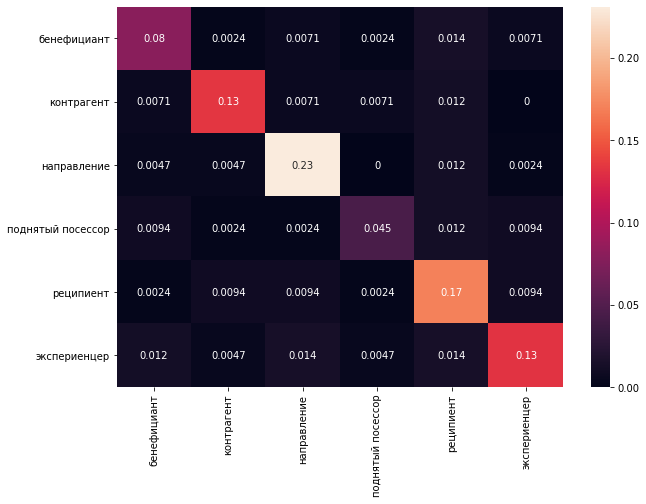

In [ ]:
logreg.fit(X_train_o, y_train_o)
y_pred = logreg.predict(X_test_o)
calculate_metrics(y_test_o, y_pred)

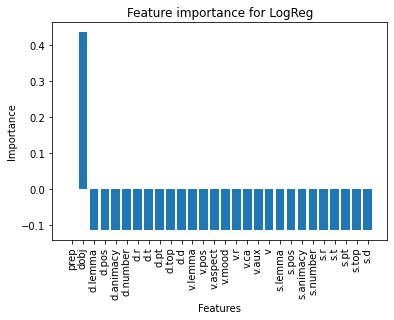

In [ ]:
importance = logreg.coef_[0].tolist()
dict_features = {}
for i, v in enumerate(importance):
  if '_' in X_train_o.columns[i]:
      feature, _ = X_train_o.columns[i].split('_', maxsplit=1)
  else: 
      feature = X_train_o.columns[i]
  if feature in dict_features:
      dict_features[feature] += v
  elif not feature.startswith('key'):
      dict_features[feature] = v

plt.bar(dict_features.keys(), dict_features.values())
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature importance for LogReg')
plt.xticks(rotation=90)
plt.show()

In [ ]:
feas = pd.DataFrame({
    'feature': X_train_o.columns,
    'importance': logreg.coef_[0].tolist()
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

In [ ]:
feas.head(15)

,feature,importance
0,v.lemma_вредить,2.249005
1,v.lemma_угрожать,2.192301
2,v.lemma_вырезать,1.263477
3,v.lemma_купить,1.205547
4,v.lemma_нравиться,1.168112
5,v.lemma_предоставить,1.101626
6,v.lemma_открыть,1.091663
7,v.lemma_заменить,1.064962
8,v.r_t:impact,0.976711
9,v.lemma_очистить,0.900040


In [ ]:
print(dict_features.keys())

dict_keys(['prep', 'dobj', 'd.lemma', 'd.pos', 'd.animacy', 'd.number', 'd.r', 'd.t', 'd.pt', 'd.top', 'd.d', 'v.lemma', 'v.pos', 'v.aspect', 'v.mood', 'v.r', 'v.ca', 'v.aux', 'v', 's.lemma', 's.pos', 's.animacy', 's.number', 's.r', 's.t', 's.pt', 's.top', 's.d'])


## 4. FNN с двумя слоями

In [ ]:
model = nn.Sequential(nn.Linear(X_train_o.shape[1], 512),
                      nn.BatchNorm1d(512),
                      nn.ReLU(),
                      nn.Linear(512, 128),
                      nn.Dropout(0.3),
                      nn.ReLU(),
                      nn.Linear(128, 6))
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001, momentum=0.7)
optimizer = optim.Adam(model.parameters())
scheduler =  optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [ ]:
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0"):
    model.train()

    for X, y in train_dataloader:
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X)
        loss = criterion(y_pred, y.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def predict(model, val_dataloader, criterion, device="cuda:0"):
    model.eval()

    losses = []
    predicted_classes = []
    true_classes = []
    with torch.no_grad():
        for X, y in tqdm(val_dataloader):
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)
            loss = criterion(y_pred, y.long())

            losses.append(loss)
            predicted_classes.extend(torch.argmax(y_pred, dim=-1).tolist())
            true_classes.extend(y.tolist())
    return losses, predicted_classes, true_classes


def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs=50, scheduler=None):
    model.to(device)
    for epoch in tqdm(range(n_epochs)):
        train_one_epoch(model, train_dataloader, criterion, optimizer)
        
        losses, pred, target = predict(model, val_dataloader, criterion)
        accuracy = accuracy_score(target, pred)
        print(f1_score(target, pred, average='weighted'))
        scheduler.step(accuracy)
        if epoch == n_epochs - 1:
            print(classification_report(target, pred))
        print(accuracy)

In [ ]:
train(model, train_loader, val_loader, criterion, optimizer, n_epochs=30, scheduler=scheduler)


0.7053558415948747
0.7216981132075472



0.7585770931124863
0.7617924528301887



0.7681343509368997
0.7688679245283019



0.7780998562600417
0.7759433962264151



0.7632344643808631
0.7641509433962265



0.7705780419959939
0.7688679245283019



0.7558785553723806
0.7547169811320755



0.7818495828377702
0.7830188679245284



0.7805580566402894
0.7830188679245284



0.7796353536258321
0.7806603773584906



0.7790601458367926
0.7830188679245284



0.7805377903367069
0.7830188679245284



0.7754102117716782
0.7783018867924528



0.7730458092250161
0.7759433962264151



0.7885532379837629
0.7924528301886793



0.7959478095867295
0.7995283018867925



0.7744003602011134
0.7759433962264151



0.769580641224401
0.7735849056603774



0.7896283216658959
0.7924528301886793



0.7859458148714259
0.7900943396226415



0.7742698804231403
0.7783018867924528



0.7916343133623718
0.7948113207547169



0.7866284413425401
0.7900943396226415



0.7891311707491616
0.7924528301886793



0.782355880787382
0.785377358490566



0.7892596004289153
0.7924528301886793



0.7770773406163791
0.7806603773584906



0.7791816208207303
0.7830188679245284



0.7915691092279842
0.7948113207547169



0.7812056530845803
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        48
           1       0.85      0.86      0.85        71
           2       0.81      0.94      0.87       108
           3       0.73      0.56      0.63        34
           4       0.74      0.79      0.76        86
           5       0.80      0.68      0.73        77

    accuracy                           0.79       424
   macro avg       0.78      0.75      0.76       424
weighted avg       0.78      0.79      0.78       424

0.785377358490566



## 5. Ансамбли деревьев

Accuracy is 0.6910377358490566
Macro F1-score is 0.672955955546873
Micro F1-score is 0.6910377358490566
Classification report: 
               precision    recall  f1-score   support

           0       0.60      0.52      0.55        54
           1       0.72      0.71      0.72        69
           2       0.74      0.76      0.75       103
           3       0.69      0.58      0.63        31
           4       0.68      0.75      0.71        93
           5       0.68      0.68      0.68        74

    accuracy                           0.69       424
   macro avg       0.68      0.67      0.67       424
weighted avg       0.69      0.69      0.69       424



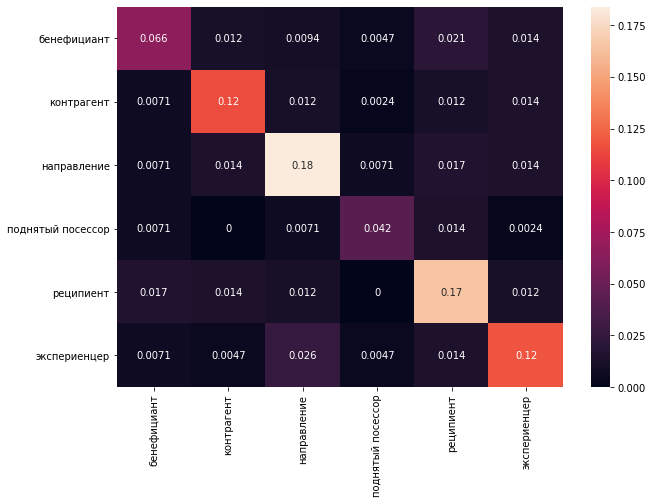

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
calculate_metrics(y_test, y_pred)

Accuracy is 0.7405660377358491
Macro F1-score is 0.7285954901359122
Micro F1-score is 0.7405660377358491
Classification report: 
               precision    recall  f1-score   support

           0       0.72      0.57      0.64        54
           1       0.77      0.84      0.81        69
           2       0.78      0.82      0.80       103
           3       0.90      0.58      0.71        31
           4       0.67      0.77      0.72        93
           5       0.73      0.69      0.71        74

    accuracy                           0.74       424
   macro avg       0.76      0.71      0.73       424
weighted avg       0.75      0.74      0.74       424



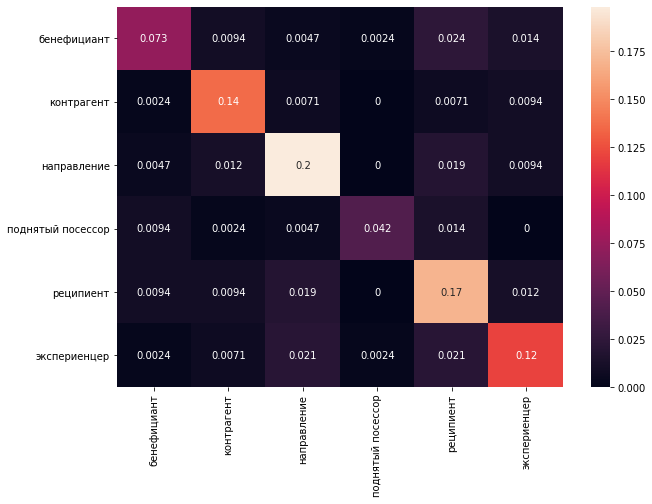

In [ ]:
clf_r = xgb.XGBClassifier(n_estimators=1000, learning_rate=1e-2, max_depth=3, silent=True)
clf_r.fit(X_train, y_train)
y_pred = clf_r.predict(X_test)
calculate_metrics(y_test, y_pred)

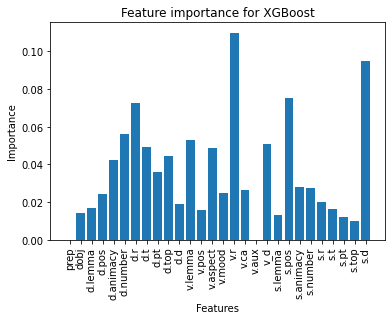

In [ ]:
feas = pd.DataFrame({
    'feature': X_train.columns,
    'importance': clf_r.feature_importances_
}).sort_values(by='importance', ascending=False).reset_index(drop=True)
plt.bar(X_train.columns, clf_r.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature importance for XGBoost')
plt.xticks(rotation=90)
plt.show()